# Final qosf Deliverable

First we have to import necessary libraries.

In [1]:
import math
import numpy as np
from scipy import linalg
from scipy import integrate
from scipy import sparse
import scipy.optimize as optimize
import qutip as qt
import os
#from EDAspy.optimization import UMDAd
import random
import matplotlib.pyplot as plt
import itertools

We define functions for spin operators.

In [2]:
# Dictionary mapping operator specifications to the corresponding operator functions
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}

def mkSpinOp(dims, specs):
    """Returns a tensor product of operators based on given dimensions and specifications.
    
    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.
    specs :
        List of index-specification pairs indicating which operator to modify and how.

    Returns
    -------
    qobj
        The matrix (tensor product of individual operators).
        
    Examples
    --------
    >>> spin_op = mkSpinOp([3, 4, 2], [(0, 'x'), (1, 'y'), (2, 'z')])
    >>> spin_op
    [[3, 4, 2], [3, 4, 2]]
    """

    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)

def idOp(dims):
    """Returns the tensor product of identity operators with given dimensions.
    
    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.

    Returns
    -------
    qobj
        The identity matrix (tensor product of individual operators).
        
    Examples
    --------
    >>> id_op = idOp([3, 4, 2])
    >>> id_op.dims
    [[3, 4, 2], [3, 4, 2]]
    """

    return mkSpinOp(dims, [])

def zeroOp(dims):
    """Returns the tensor product of zero operators with given dimensions.

    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.

    Returns
    -------
    qobj
        The zero matrix (tensor product of individual operators).
        
    Examples
    --------
    >>> zero_op = zeroOp([3, 4, 2])
    >>> zero_op.dims
    [[3, 4, 2], [3, 4, 2]]
    """

    d = np.prod(dims)
    return qt.Qobj(sparse.csr_matrix((d, d), dtype=np.float64), 
                       dims=[list(dims)]*2, type="oper", isherm=True) 

We define functions for Hamiltonian operators.

In [3]:
def mkH1(dims, ind, parvec):
    """Returns the Hamiltonian operator based on the given dimensions, index, and parameter vector.

    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.
    ind : int
        Index indicating which operator to modify.
    parvec : list of float
        List of parameter values for each spin component. (???)

    Returns
    -------
    qutip.qobj
        The Hamiltonian operator.
        
    Examples
    --------
    >>> H1 = mkH1([3, 4, 2], 1, [1.0, 0.5, 0.1])
    >>> H1.dims
    [[3, 4, 2], [3, 4, 2]]
    """

    axes = ['x', 'y', 'z']
    components = [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0]
    if components:
        return sum(components)
    else:
        return zeroOp(dims)

def mkH12(dims, ind1, ind2, parmat):
    """Returns the Hamiltonian operator based on the given dimensions, indices, and parameter matrix.
    
    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.
    ind1 : int
        Index indicating the first operator to modify.
    ind2 : int
        Index indicating the second operator to modify.
    parmat : np.ndarray
        Parameter matrix specifying the coupling strengths. (???)

    Returns
    -------
    qutip.qobj
        The Hamiltonian operator.
        
    Examples
    --------
    >>> H12 = mkH12([3, 4, 2], 0, 1, np.array([[1.0, 0.5, -0.3], [0.5, 0.0, 0.2], [-0.3, 0.2, 0.7]]))
    >>> H12.dims
    [[3, 4, 2], [3, 4, 2]]
    """
    
    axes = ['x', 'y', 'z']
    components = []
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                components.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    if components:
        return sum(components)
    else:
        return zeroOp(dims)

We define function for the dense of an operator.

In [4]:
def dense(op):
    """Returns the dense array representation of the given operator.

    Parameters
    ----------
    op : Union[qutip.qobj.Qobj, scipy.sparse.csc_matrix]
        The input operator.

    Returns
    -------
    numpy.ndarray
        The dense array representation of the operator.
        
    Examples
    --------
    >>> operator = qt.Qobj([[1, 2], [3, 4]])
    
    # Get the dense array representation of the operator
    >>> dense_op = dense(operator)
    array([[1.+0.j, 2.+0.j], 
        [3.+0.j, 4.+0.j]])
    """
    
    if type(op) is qt.qobj.Qobj:
        return np.asarray(op.data.todense())
    else:
        return np.asarray(op.todense())

$$
\text{Trace}({\rho(t) Z})
$$

for 

$$
\rho(t) = U(t)\rho(0) U^{\dagger}(t)
$$

We define functions for computing expectation values.

In [5]:
def expvalsConstH(Heff, rho0, ops, dt, nr_steps):
    """Returns the expectation values of operators and the final density matrix.

    Parameters
    ----------
    Heff : numpy.ndarray
        The effective Hamiltonian.
    rho0 : numpy.ndarray
        The initial density matrix.
    ops : list of numpy.ndarray
        List of operators for which expectation values are computed.
    dt : float
        The time step size.
    nr_steps : int
        The number of steps in the evolution.

    Returns
    -------
    obs : numpy.ndarray
        The expectation values of the operators over time.
    rhot : numpy.ndarray
        The final density matrix.
        
    Examples
    --------
    >>> Heff = np.array([[1, 0], [0, -1]])
    >>> rho0 = np.array([[1, 0], [0, 0]])
    >>> ops = [np.array([[1, 0], [0, 1]]), np.array([[0, 1], [1, 0]])]
    >>> dt = 0.1
    >>> nr_steps = 10

    # Compute the expectation values and final density matrix
    >>> obs, rhot = expvalsConstH(Heff, rho0, ops, dt, nr_steps)
    >>> obs
    array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
    >>> rhot
    array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])
    """

    obs = np.zeros((len(ops),nr_steps))
    rhot = rho0
    U = linalg.expm(-1j*dt*Heff)
    for i in range(nr_steps):
        rhot = U @ rhot @ U.T.conjugate()
        for s in range(len(ops)):
            obs[s,i] = np.real(np.trace(ops[s] @ rhot))
                
    return obs, rhot

def expvalsPiecewiseConstHt(H0, H1, u, rho0, ops, dt):
    """Returns the expectation values of operators and the final density matrix.

    Parameters
    ----------
    H0 : numpy.ndarray
        The initial fixed Hamiltonian.
    H1 : numpy.ndarray
        The drift (control) time-dependent Hamiltonian.
    u : numpy.ndarray
        The magnetic field (dependent variable).
    rho0 : numpy.ndarray
        The initial density matrix.
    ops : list of numpy.ndarray
        List of operators for which expectation values are computed.
    dt : float
        The time step size.
    
    Returns
    -------
    obs : numpy.ndarray
        The expectation values of the operators over time.
    rhot : numpy.ndarray
        The final density matrix.
        
    Examples
    --------
    >>> H0 = np.array([[1, 0], [0, -1]])
    >>> H1 = np.array([[0, 1], [1, 0]])
    >>> u = np.array([0.1, 0.2, 0.3])
    >>> rho0 = np.array([[1, 0], [0, 0]])
    >>> ops = [np.array([[1, 0], [0, 1]]), np.array([[0, 1], [1, 0]])]
    >>> dt = 0.01

    # Compute the expectation values and final density matrix
    >>> obs, rhot = expvalsPiecewiseConstHt(H0, H1, u, rho0, ops, dt)
    >>> obs
    array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.99993267e-05, 9.99883939e-05, 2.79931701e-04]])
    >>> rhot
    array([[9.99964010e-01+1.73472348e-18j, 1.39965851e-04+5.99745641e-03j],
       [1.39965851e-04-5.99745641e-03j, 3.59903691e-05+0.00000000e+00j]])
    """

    nr_steps = len(u)

    obs = np.zeros((len(ops),nr_steps))
    rhot = rho0
    for i in range(nr_steps):
        Hi = H0 + u[i] * H1
        Ui = linalg.expm(-1j*dt*Hi)
        rhot = Ui @ rhot @ Ui.T.conjugate()
        for s in range(len(ops)):
            obs[s,i] = np.real(np.trace(ops[s] @ rhot))
                
    return obs, rhot

In [6]:
# exp(iθn⋅σ) = cosθ I+i(n⋅σ)sinθ
# exp(-iudt Sx) = exp(-iudt/2 σx) = cos(udt/2) I - iσx sin(udt/2)
def expm_trotter_H1x(expiA, b1, u, ds, nr_halvings):
    """Returns the approximate exponential of a Hamiltonian.

    Parameters
    ----------
    expiA : numpy.ndarray
        The exponential of the A Hamiltonian.
    b1 : XXX
        xxx
    u : numpy.ndarray
        The magnetic field (dependent variable)
    ds : int
        Time step size.
    nr_halvings : int
        The number of halvings.

    Returns
    -------
    U : numpy.ndarray
        The approximate exponential of the Hamiltonian.
        
    Examples
    --------
    >>> expiA = np.eye(4)
    >>> b1 = 0.1
    >>> u = 0.1
    >>> ds = 0.01
    >>> nr_halvings = 3

    # Compute the approximate exponential of the Hamiltonian
    >>> U = expm_trotter_H1x(expiA, b1, u, ds, nr_halvings)
    """

    dim_n = expiA.shape[0]//4
    omega = b1*u*ds/2
    c = np.cos(omega)
    s = -1j * np.sin(omega)
    expiB_1 = np.array([[c,s],[s,c]])
    dexpiB_1 = (-1j*ds*b1/2) * np.array([[s,c],[c,s]])
    expiB_12 = np.kron(expiB_1, expiB_1)
    dexpiB_12 = np.kron(dexpiB_1, expiB_1) + np.kron(expiB_1, dexpiB_1)
    # expiB = sparse.kron(expiB_12, sparse.eye(dim_n, format="csr"))
    # dexpiB = sparse.kron(dexpiB_12, sparse.eye(dim_n, format="csr"))
    # expiB = sparse.kron(sparse.csr_matrix(expiB_12), qt.fastsparse.fast_identity(dim_n))
    # dexpiB = sparse.kron(sparse.csr_matrix(dexpiB_12), qt.fastsparse.fast_identity(dim_n))
    expiB = np.kron(expiB_12, np.eye(dim_n))
    dexpiB = np.kron(dexpiB_12, np.eye(dim_n))
    U = expiA @ (expiB @ expiA)
    L = expiA @ (dexpiB @ expiA)
    for i in range(nr_halvings, 0, -1):
        L = U @ L + L @ U
        U = U @ U
    return U

### Cost functions adapted from arXiv:2306.08613 

In [7]:
def expvalGradMultiSamples2(H0, H1, u, rho0, op, dt, w):
    
    nr_samples = len(w)
    nr_steps = len(u)
#    assert(np.mod(nr_steps, nr_samples) == 0)
    nr_substeps = nr_steps//nr_samples
    
    U_list = []
    for i in range(nr_steps):
        Hi = H0 + u[i] * H1
        Ui, _ = linalg.expm_frechet(-1j*dt*Hi, -1j*dt*H1) #GRADIENT HERE
        U_list.append(Ui)
        
    obs = 0.0
        
    Uf = np.eye(H0.shape[0]) # after loop: UnUn-1...U1U0
#    dUUf_list = [] # GRADIENT HERE
#    Ub_list = []   # GRADIENT HERE
    for j in range(nr_samples):
        m = j * nr_substeps
        n = m + nr_substeps
        Ub_list_j = []
        Ub = np.eye(H0.shape[0]) # after loop: UnUn-1...Um
        for i in range(nr_substeps):
            Ui = U_list[i + m] #GRADIENT HERE?
#            dUUf_list.append(dUi @ Uf) #GRADIENT HERE?
            Uf = Ui @ Uf
            Ub_list_j.insert(0, Ub) #GRADIENT HERE?
            Ub = Ub @ U_list[n-1-i][0]
#        for i in range(len(Ub_list)):
#            Ub_list[i] = Ub @ Ub_list[i]
#        Ub_list = Ub_list + Ub_list_j
        A = rho0 @ Uf.T.conjugate() 
        #print(A.shape)
        B = A @ op
        BT = B.T
        # obs += w[j] * np.real(np.trace(Uf @ B))
        obs += w[j] * np.real(np.sum(Uf.__mul__(BT)))
            
    rhot = Uf @ A
        
    return obs, Uf


def expvalGradMultiSamplesSplitTrotterH1x2(H0, b1, u, rho0, op, dt, w, nr_halvings=4):
    
    nr_samples = len(w)
    nr_steps = len(u)
#    assert(np.mod(nr_steps, nr_samples) == 0)
    nr_substeps = nr_steps//nr_samples
    
    dim = rho0.shape[0]
    
    ds = dt / 2**nr_halvings
    UA = linalg.expm(-1j*ds/2*H0) 
    
    U_list = []
    for i in range(nr_steps):
        # Hi = H0 + u[i] * H1 
        # Ui, dUi = linalg.expm_frechet(-1j*dt*Hi, -1j*dt*H1)
        Ui, _ = expm_trotter_H1x(UA, b1, u[i], ds, nr_halvings)
        U_list.append((Ui,dUi))
        
    obs = 0.0
        
    Uf = np.eye(dim) # after loop: UnUn-1...U1U0
#    dUUf_list = [] # [dU0, dU1U0, dU2U1U0, dU3U2U1U0, ..., dUnUn-1...U1U0] #GRADIENT HERE
    Ub_list = []   # [Un...U2U1, Un...U2, ..., UnUn-1Un-2, UnUn-1, Un, 1] #GRADIENT HERE
    for j in range(nr_samples):
        m = j * nr_substeps
        n = m + nr_substeps
        Ub_list_j = []
        Ub = np.eye(dim) # after loop: UnUn-1...Um
        for i in range(nr_substeps):
            Ui, dUi = U_list[i + m]
#            dUUf_list.append(dUi @ Uf) #GRADIENT HERE
            Uf = Ui @ Uf
            Ub_list_j.insert(0, Ub)
            Ub = Ub @ U_list[n-1-i][0]
        for i in range(len(Ub_list)):
            Ub_list[i] = Ub @ Ub_list[i]
        Ub_list = Ub_list + Ub_list_j
        A = rho0 @ Uf.T.conjugate()
        #print(A.shape)
        B = A @ op
        BT = B.T
        # obs += w[j] * np.real(np.trace(Uf @ B))
        obs += w[j] * np.real(np.sum(Uf.__mul__(BT)))
        
            
    rhot = Uf @ A
        
    return obs, Uf

In [8]:
def fun2(u, H0, H1, rho0, obs, dt, w, minimize):
    if type(H1) == float:
        ys,_ = expvalGradMultiSamplesSplitTrotterH1x2(H0, H1, u, rho0, obs, dt, w)
    else:
        ys,_ = expvalGradMultiSamples2(H0, H1, u, rho0, obs, dt, w)
    if not minimize:
        ys = -ys
        #grad = -grad
           
    return ys

We look at a generalisation of the system studied in this paper: https://aip.scitation.org/doi/abs/10.1063/1.5131557

In [9]:
def mkSystem(b0, b1, kS, k0):

    g = 2.00231930436256 #electron g-factor
    beta = 9.274009994e-24 #bohr magneton
    hbar = 6.62607015e-34/(2*np.pi) #hbar
    mT = g*beta/hbar*1e-9 # mT -> Mrad/s

    omega0 = b0*mT
    omega1 = b1*mT
    Is = [0.5, 0.5, 0.5, 0.5, 0.5]
    indE = [0, 0, 0, 1, 1]
    hfcs = np.array([0.2, 0.5, 1.0, 0.2, 0.3]) * mT # mT -> Mrad/s
    jex = 1 * 2*math.pi

    dims = [2, 2] + [round(2*Is[i]+1) for i in range(len(Is))]
    Hhfc = sum(mkH12(dims, indE[i], i+2, np.eye(3)*hfcs[i]) for i in range(len(hfcs)))
    Hzee = mkH1(dims, 0, [0,0,omega0]) + mkH1(dims, 1, [0,0,omega0])
    Hex = -jex * (1/2*mkSpinOp(dims, []) + mkH12(dims, 0, 1, 2*np.identity(3)))
    H0 = Hhfc + Hzee + Hex
    H1 = mkH1(dims, 0, [omega1,0,0]) + mkH1(dims, 1, [omega1,0,0])
    Ps = 0.25 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.eye(3))
    H = H0 - 1j * kS/2 * Ps
    rho0 = Ps/Ps.tr()
    H, H1, rho0 = [dense(op) for op in (H, H1, rho0)]
    Ps = Ps.data

    sys = {
        'Is': Is,
        'indE': indE,
        'hfcs': hfcs,
        'jex': jex,
        'omega0': omega0,
        'omega1': omega1,
        'kS': kS,
        'k0': k0
    }

    return H, H1, omega1, rho0, Ps, sys

In [10]:
def optimizeYield(name, b0, b1, kS, k0, nr_cycles, nr_steps, nr_samples, eda_opt):

    # Optimize singlet probability after nr_steps steps of dt usind L-BFGS-B

    dt = 0.001
    nr_total = max(math.ceil(5/k0) * 1000, nr_cycles*nr_steps)
    nr_iter = 200
    minimize = True

    t_sampled = (np.arange(nr_samples) + 1) * (nr_steps//nr_samples)*dt # without t0
    # w = np.ones(nr_samples)
    w = np.exp(-t_sampled*k0) * k0 * (nr_steps//nr_samples)*dt

    H, H1, omega1, rho0, Ps, sys = mkSystem(b0, b1, kS, k0)

    rho = rho0
    
    #stats = []
    uopt_all = []
    for i in range(nr_cycles):
        u0 = np.random.randn(nr_steps)
        ind = np.where(np.abs(u0) > 1)[0]
        u0[ind] = np.sign(u0[ind])
        
        if eda_opt:
            eda = UMDAd(size_gen=30, max_iter=100, dead_iter=10, n_variables=8, alpha=0.5, vector=None,
            lower_bound=0.2, upper_bound=0.9, elite_factor=0.2, disp=True)

            eda_result = eda.minimize(cost_function=fun2(u0, H, H1, rho0, obs, dt, w, minimize), output_runtime=True)
            
            """
            CHANGE THIS LINE ABOVE WITH THE CORRECT OBS!!!!!
            """
            
            #eda_result = eda.minimize(cost_function=fun2(u0, H, H1, rho0, obs = np.eye(128), dt, w, minimize),
            #                          output_runtime= True)
        else:
            opt = optimize.minimize(fun, u0, 
                        args=(H, omega1, rho, Ps, dt, w, minimize),
                        method='L-BFGS-B',
                        jac=True, bounds=[(-1,1) for _ in range(len(u0))],
                        options={'disp': 0, 'maxcor': 60, 'ftol': 1e-6, 'gtol': 1e-7, 'maxiter': nr_iter})
            print(opt.message)
            print(opt.fun)
        
        
        u = opt.x
        uopt_all.append(u)
        #stats.append((opt.fun, opt.nit, opt.nfev, opt.success))
        
        ps, rho = expvalsPiecewiseConstHt(H, H1, u, rho, [Ps], dt)
        
    u = np.concatenate(uopt_all)
    u = np.concatenate((u, np.zeros(nr_total-len(u))))
    t = np.arange(len(u))*dt
    ps, _ = expvalsPiecewiseConstHt(H, H1, u, rho0, [Ps], dt)
    ps = ps[0]
    ys = integrate.simps(ps*k0*np.exp(-k0*t))*dt
    ps0, _ = expvalsConstH(H, rho0, [Ps], dt, nr_total)
    ps0 = ps0[0]
    ys0 = integrate.simps(ps0*k0*np.exp(-k0*t))*dt
    print("{} x {} @ {} : {} vs. {}".format(nr_cycles, nr_steps, nr_samples, ys, ys0))
    
    np.savez(name, sys=sys, u=u, 
             nr_cycles=nr_cycles, nr_steps=nr_steps, nr_samples=nr_samples, nr_iter=nr_iter, minimize=minimize,
             ys=ys, ys0=ys0, ps=ps, ps0=ps0) #stats=stats)

    return ys, ps #, stats

## Now we train normally! 

In [11]:
nr_cycles = 1       # number of cycles
nr_steps = 1000     # number of steps
dt = 0.001          # time step
nr_samples = 100    # number of samples

b0 = 0.05 # mT (this is the geomagnetic field, relavant to avian magnetoreception)
b1 = 0.25 # mT, free to try different parameters here
k0 = 1.0 # 1/us
kS = 1.0 # 1/us

nr_total = max(math.ceil(5/k0) * 1000, nr_cycles*nr_steps)
nr_iter = 200
minimize = True     # are we using minimalization or maximalization function?

t_sampled = (np.arange(nr_samples) + 1) * (nr_steps//nr_samples)*dt # without t0
# w = np.ones(nr_samples)
w = np.exp(-t_sampled*k0) * k0 * (nr_steps//nr_samples)*dt

H, H1, omega1, rho0, Ps, sys = mkSystem(b0, b1, kS, k0)

rho = rho0

#obs = np.eye(128,128)
obs = Ps


for i in range(100):
    u0 = np.random.randn(100)
    ind = np.where(np.abs(u0) > 1)[0]
    u0[ind] = np.sign(u0[ind])

args = (H, H1, rho0, obs, dt, w, minimize)
fun2(u0, *args)

0.11073322036950685

For training our model, we will use Tensorflow.

In [12]:
import time as time
import tensorflow as tf

In [13]:
number_genes, number_daughters, change = 5, 40, 1e-5
number_generations = int(1e4)
patience = 500

#initial_guess = best_u0 #We carry the result from our previous hypervalidation result
initial_guess = u0

best_cost = 10000

distance = 0
change_altered = False #Variable to allow to diminish the change back

history = []
history.append(fun2(initial_guess,*args))

generations = []

with tf.device("/GPU:0"):
    for generation in range(number_generations):
        print("Generation {} / {} ".format(generation, number_generations-1))

        daughters = []
        daughters_cost = []

        for u in range(number_daughters):
            random_indexes = [1]*number_genes + [0]*(len(u0)-number_genes)
            random_indexes = random.shuffle(random_indexes)
            random_changes = np.random.uniform(low=-change, high=change, size=(len(initial_guess),))
            v = initial_guess.copy() #Auxiliary variable
            v[random_indexes] = v[random_indexes] + random_changes

            #We now normalize from -1 to 1 in case we have a higher v
            ind = np.where(np.abs(v) > 1)[0]
            v[ind] = np.sign(v[ind])

            # We now save the daughter to the list
            daughters.append(v)

            #We now measure which one is best out of all of these

        for daughter in daughters:
            daughters_cost.append(fun2(daughter, *args))

        winner_cost = min(daughters_cost)
        winner_daughter = daughters[daughters_cost.index( winner_cost )]

        initial_guess = winner_daughter
        
        if winner_cost < best_cost:
            best_cost = winner_cost
            best_u0 = winner_daughter
            distance = 0
            #if change_altered:
            #    change = change // 10 #We diminish the change once again
            #    change_altered = False
        
        
        if distance >= (patience//5) and not change_altered:
            #When the code is getting stale, increase the number of change
            change = change*10
            change_altered = True
            print("Changing the change from {} to {}".format(change/10, change))
        
        if distance >= patience:
            #When the patience is reached stop minimizing
            print("Patience has been reached!")
            break
        
        distance = distance + 1

        history.append(winner_cost)
        generations.append(winner_daughter)
        print("Best cost: ",winner_cost)
        print("Cost change: ", history[generation]-history[generation-1])
        print("==========================================")

Generation 0 / 499 
Best cost:  0.11072863449728003
Cost change:  4.5858722268199426e-06
Generation 1 / 499 
Best cost:  0.11072107292573909
Cost change:  -4.5858722268199426e-06
Generation 2 / 499 
Best cost:  0.11071708577372932
Cost change:  -7.561571540942724e-06
Generation 3 / 499 
Best cost:  0.11071237001083496
Cost change:  -3.987152009762851e-06
Generation 4 / 499 
Best cost:  0.11070842272873455
Cost change:  -4.715762894361153e-06
Generation 5 / 499 
Best cost:  0.1107050655778332
Cost change:  -3.947282100416616e-06
Generation 6 / 499 
Best cost:  0.11069882632879213
Cost change:  -3.357150901342476e-06
Generation 7 / 499 
Best cost:  0.11069169740480767
Cost change:  -6.239249041070649e-06
Generation 8 / 499 
Best cost:  0.11068362450017852
Cost change:  -7.128923984467406e-06
Generation 9 / 499 
Best cost:  0.11067516817348402
Cost change:  -8.072904629147226e-06
Generation 10 / 499 
Best cost:  0.1106700004895817
Cost change:  -8.456326694494809e-06
Generation 11 / 499 


Best cost:  0.11033661346164512
Cost change:  -4.207536176623061e-06
Generation 63 / 499 
Best cost:  0.11032752935573018
Cost change:  -7.764284167113833e-06
Generation 64 / 499 
Best cost:  0.11032083777345736
Cost change:  -9.084105914949903e-06
Generation 65 / 499 
Best cost:  0.11031334835441071
Cost change:  -6.69158227281641e-06
Generation 66 / 499 
Best cost:  0.1103068610039126
Cost change:  -7.489419046644019e-06
Generation 67 / 499 
Best cost:  0.11029643005143142
Cost change:  -6.487350498116107e-06
Generation 68 / 499 
Best cost:  0.11029330320031674
Cost change:  -1.0430952481182976e-05
Generation 69 / 499 
Best cost:  0.11029007894476539
Cost change:  -3.1268511146709255e-06
Generation 70 / 499 
Best cost:  0.11028385729256003
Cost change:  -3.2242555513539717e-06
Generation 71 / 499 
Best cost:  0.1102766298169371
Cost change:  -6.221652205359862e-06
Generation 72 / 499 
Best cost:  0.11026955316804768
Cost change:  -7.22747562292847e-06
Generation 73 / 499 
Best cost: 

Best cost:  0.10982398008320213
Cost change:  -7.573517996004031e-06
Generation 125 / 499 
Best cost:  0.10981623373986008
Cost change:  -1.353841714592241e-05
Generation 126 / 499 
Best cost:  0.10980666471439626
Cost change:  -7.746343342052153e-06
Generation 127 / 499 
Best cost:  0.1098011327347038
Cost change:  -9.569025463812553e-06
Generation 128 / 499 
Best cost:  0.10979256884756945
Cost change:  -5.531979692469102e-06
Generation 129 / 499 
Best cost:  0.10977984513949485
Cost change:  -8.563887134341308e-06
Generation 130 / 499 
Best cost:  0.10977143986765339
Cost change:  -1.27237080746051e-05
Generation 131 / 499 
Best cost:  0.10976058129876312
Cost change:  -8.40527184145512e-06
Generation 132 / 499 
Best cost:  0.10975302627434474
Cost change:  -1.0858568890270703e-05
Generation 133 / 499 
Best cost:  0.10974371175788593
Cost change:  -7.55502441837641e-06
Generation 134 / 499 
Best cost:  0.10973483321106811
Cost change:  -9.314516458816535e-06
Generation 135 / 499 
Be

Best cost:  0.10922012682514819
Cost change:  -1.027967107813943e-05
Generation 187 / 499 
Best cost:  0.10921143052315256
Cost change:  -7.758338437996448e-06
Generation 188 / 499 
Best cost:  0.10920251135974576
Cost change:  -8.696301995625433e-06
Generation 189 / 499 
Best cost:  0.1091911065224031
Cost change:  -8.919163406798103e-06
Generation 190 / 499 
Best cost:  0.10918164864253557
Cost change:  -1.1404837342660068e-05
Generation 191 / 499 
Best cost:  0.10917241251310555
Cost change:  -9.457879867530439e-06
Generation 192 / 499 
Best cost:  0.10916113073740272
Cost change:  -9.236129430018059e-06
Generation 193 / 499 
Best cost:  0.10915044500912002
Cost change:  -1.1281775702837171e-05
Generation 194 / 499 
Best cost:  0.10914104130825157
Cost change:  -1.0685728282694429e-05
Generation 195 / 499 
Best cost:  0.10913158205446583
Cost change:  -9.403700868451659e-06
Generation 196 / 499 
Best cost:  0.1091243384089837
Cost change:  -9.459253785745747e-06
Generation 197 / 499

Best cost:  0.10857014268046936
Cost change:  -7.8365153525356e-06
Generation 249 / 499 
Best cost:  0.10855762620179024
Cost change:  -1.0333820375879599e-05
Generation 250 / 499 
Best cost:  0.10854609245873265
Cost change:  -1.2516478679114318e-05
Generation 251 / 499 
Best cost:  0.10852963846345062
Cost change:  -1.1533743057595691e-05
Generation 252 / 499 
Best cost:  0.10851195812969897
Cost change:  -1.645399528202307e-05
Generation 253 / 499 
Best cost:  0.10850385265827503
Cost change:  -1.768033375165734e-05
Generation 254 / 499 
Best cost:  0.10849664672864712
Cost change:  -8.105471423935917e-06
Generation 255 / 499 
Best cost:  0.10849066243540896
Cost change:  -7.205929627912555e-06
Generation 256 / 499 
Best cost:  0.10848402303531704
Cost change:  -5.984293238156524e-06
Generation 257 / 499 
Best cost:  0.10847989726250125
Cost change:  -6.639400091920655e-06
Generation 258 / 499 
Best cost:  0.10846832241206388
Cost change:  -4.125772815791184e-06
Generation 259 / 499

Best cost:  0.10789311909200631
Cost change:  -1.3824194952383184e-05
Generation 311 / 499 
Best cost:  0.10788687865975612
Cost change:  -5.95029680963699e-06
Generation 312 / 499 
Best cost:  0.1078735903430108
Cost change:  -6.2404322501985465e-06
Generation 313 / 499 
Best cost:  0.10786690980604807
Cost change:  -1.3288316745310724e-05
Generation 314 / 499 
Best cost:  0.10785704160326022
Cost change:  -6.680536962733186e-06
Generation 315 / 499 
Best cost:  0.10784772629099938
Cost change:  -9.868202787852165e-06
Generation 316 / 499 
Best cost:  0.10783191731161108
Cost change:  -9.315312260838038e-06
Generation 317 / 499 
Best cost:  0.10782013418095471
Cost change:  -1.5808979388298727e-05
Generation 318 / 499 
Best cost:  0.1078062516642909
Cost change:  -1.1783130656375929e-05
Generation 319 / 499 
Best cost:  0.10779591058989885
Cost change:  -1.3882516663801803e-05
Generation 320 / 499 
Best cost:  0.10778854939320283
Cost change:  -1.0341074392059002e-05
Generation 321 / 

Best cost:  0.10720237690408296
Cost change:  -1.270318707718987e-05
Generation 372 / 499 
Best cost:  0.10719685795300224
Cost change:  -1.7385462040372945e-05
Generation 373 / 499 
Best cost:  0.1071859443417619
Cost change:  -5.518951080724088e-06
Generation 374 / 499 
Best cost:  0.10717404322940502
Cost change:  -1.0913611240337406e-05
Generation 375 / 499 
Best cost:  0.10716394243051985
Cost change:  -1.1901112356882404e-05
Generation 376 / 499 
Best cost:  0.10715062911176246
Cost change:  -1.0100798885165352e-05
Generation 377 / 499 
Best cost:  0.10714213254955757
Cost change:  -1.3313318757396386e-05
Generation 378 / 499 
Best cost:  0.10713037744330069
Cost change:  -8.496562204890479e-06
Generation 379 / 499 
Best cost:  0.10711875367309823
Cost change:  -1.1755106256880477e-05
Generation 380 / 499 
Best cost:  0.10711157525368298
Cost change:  -1.1623770202459638e-05
Generation 381 / 499 
Best cost:  0.1071044487310549
Cost change:  -7.178419415249104e-06
Generation 382 /

Best cost:  0.10656593048951088
Cost change:  -9.367253959835509e-06
Generation 434 / 499 
Best cost:  0.10655762138957947
Cost change:  -9.147492208594343e-06
Generation 435 / 499 
Best cost:  0.10654815823049932
Cost change:  -8.309099931408381e-06
Generation 436 / 499 
Best cost:  0.10653908582834791
Cost change:  -9.46315908015305e-06
Generation 437 / 499 
Best cost:  0.10652935233875828
Cost change:  -9.072402151408254e-06
Generation 438 / 499 
Best cost:  0.10652796519925795
Cost change:  -9.733489589630606e-06
Generation 439 / 499 
Best cost:  0.10651094698473955
Cost change:  -1.387139500333423e-06
Generation 440 / 499 
Best cost:  0.10650328959337976
Cost change:  -1.701821451839669e-05
Generation 441 / 499 
Best cost:  0.10649454034767293
Cost change:  -7.657391359786048e-06
Generation 442 / 499 
Best cost:  0.1064876500378149
Cost change:  -8.74924570683222e-06
Generation 443 / 499 
Best cost:  0.10647661678798638
Cost change:  -6.890309858037513e-06
Generation 444 / 499 
Be

Best cost:  0.1058963767700468
Cost change:  -8.981815551339922e-06
Generation 496 / 499 
Best cost:  0.10588243123413668
Cost change:  -6.355148409992184e-06
Generation 497 / 499 
Best cost:  0.10587386710107152
Cost change:  -1.3945535910123152e-05
Generation 498 / 499 
Best cost:  0.10586481925894008
Cost change:  -8.564133065158686e-06
Generation 499 / 499 
Best cost:  0.10585671318739417
Cost change:  -9.047842131446049e-06


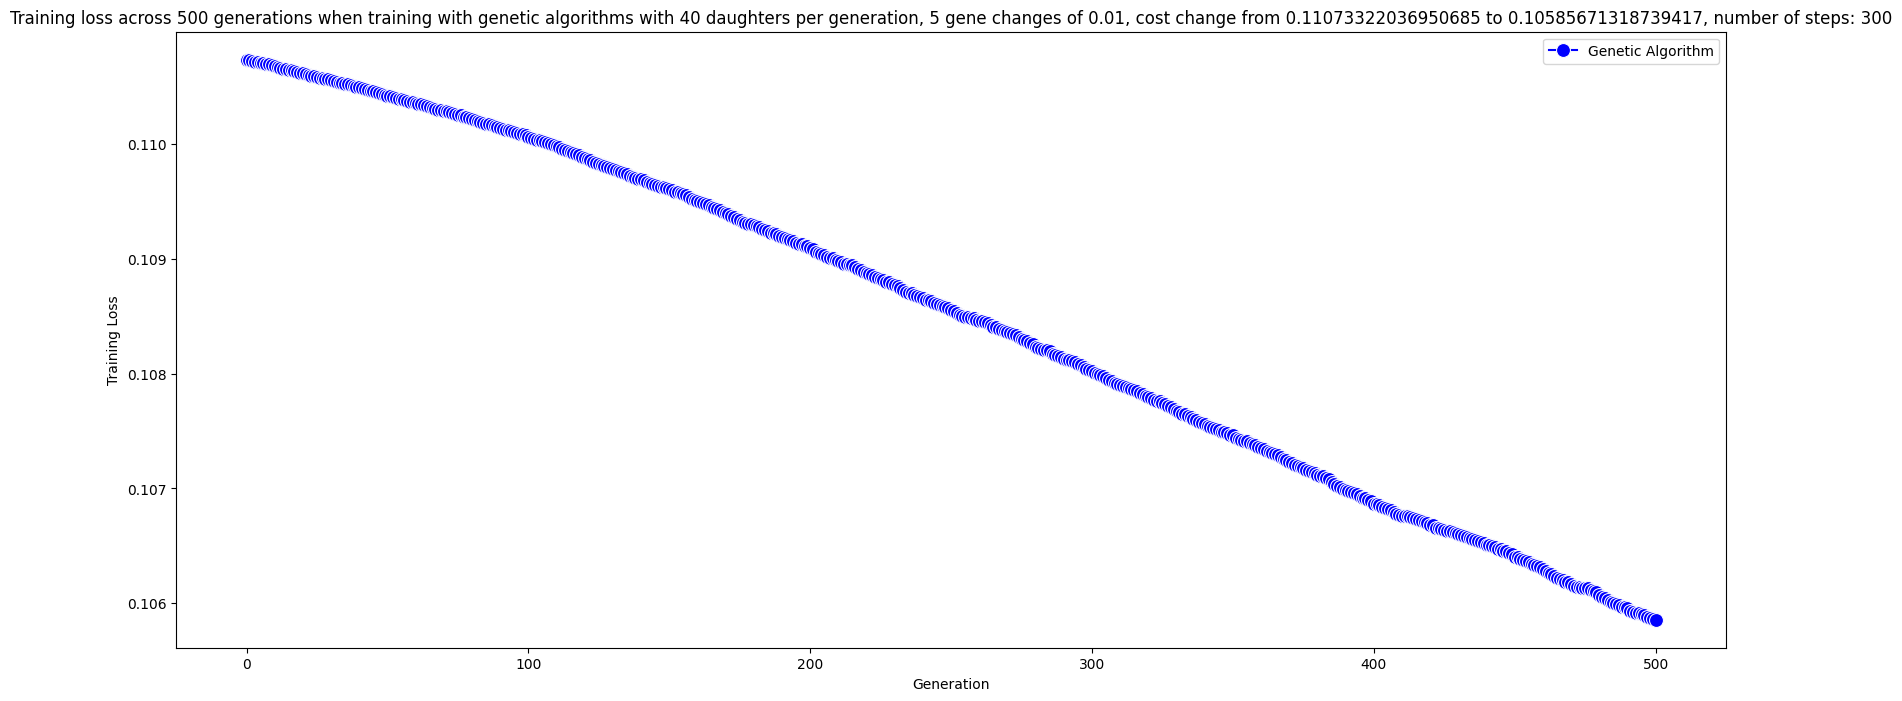

In [14]:
import seaborn as sns
name = "Training loss across {} generations when training with genetic algorithms with {} daughters per generation, {} gene changes of {}, cost change from {} to {}, number of steps: {}".format(number_generations, number_daughters, number_genes,change, history[0], history[-1], nr_steps)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = range(len(history)), y = history, label = "Genetic Algorithm", marker = "o", color = "blue", markersize = 10)
ax.set_title(name)
ax.set_ylabel('Training Loss')
ax.set_xlabel('Generation')
ax.legend()
plt.savefig("Training_loss_genetic.pdf")
plt.show()

In [15]:
history[-1]

0.10585671318739417

## Final obtained magnetic field pulses

In [16]:
print("Number of cycles: ", nr_cycles)
print("Number of steps: ", nr_steps)
print("Number of samples: ", nr_samples)

Number of cycles:  1
Number of steps:  300
Number of samples:  100


Best cost:  0.10585671318739417


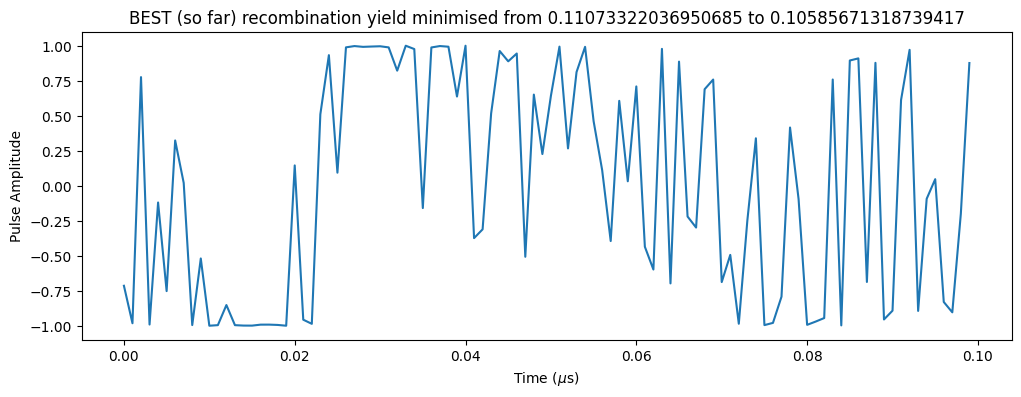

In [17]:
print("Best cost: ", best_cost)
#print("Winner configurations: ", configurations)
#print("Best u0: ",best_u0)

t = np.arange(len(best_u0)) * 0.001
plt.figure(figsize=(12,4))
plt.plot(t,best_u0)
plt.title("BEST (so far) recombination yield minimised from {} to {}".format(history[0], best_cost))
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Pulse Amplitude")
plt.savefig("Best_Magnetic_Field_Genetic.pdf")

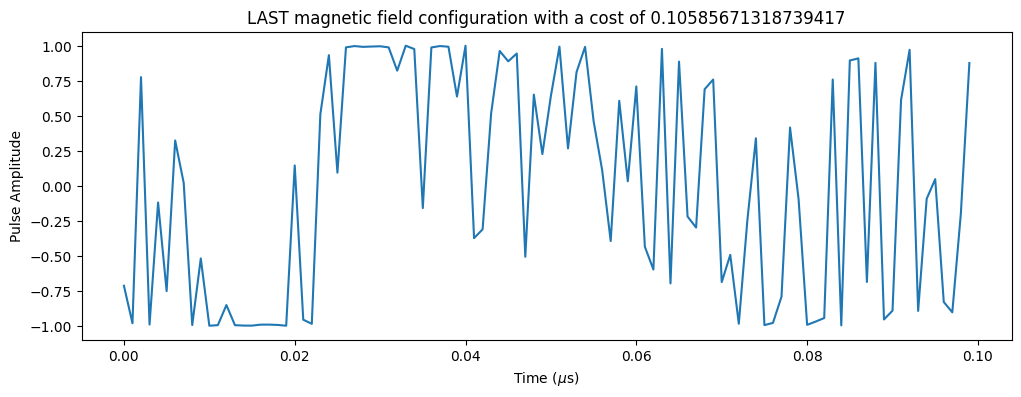

In [18]:
t = np.arange(len(generations[-1])) * 0.001
plt.figure(figsize=(12,4))
plt.plot(t,generations[-1])
plt.title("LAST magnetic field configuration with a cost of {}".format(history[-1]))
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Pulse Amplitude")
plt.savefig("Last_Magnetic_Field_Genetic.pdf")

## Saving the magnetic field configuration

We save the obtained magnetic field configuration into a .txt file.

In [19]:
np.savetxt("Best_U0.txt", best_u0, fmt = "%f")
np.savetxt("LastMagneticField.txt", generations[-1], fmt = "%f")

We can then load the data from our file.

In [20]:
# Loading the variable
np.loadtxt("Best_U0.txt", dtype = float)

array([-0.714641, -0.982284,  0.775837, -0.991519, -0.119753, -0.752723,
        0.323296,  0.019922, -0.995318, -0.519639, -1.      , -0.995896,
       -0.85236 , -0.995983, -0.998967, -0.999265, -0.992361, -0.992128,
       -0.994384, -1.      ,  0.145061, -0.95697 , -0.986479,  0.510324,
        0.932657,  0.093162,  0.988371,  0.997538,  0.991891,  0.994177,
        0.996134,  0.988041,  0.821986,  1.      ,  0.97623 , -0.159602,
        0.987614,  0.997635,  0.992927,  0.637248,  1.      , -0.37422 ,
       -0.311468,  0.516873,  0.962363,  0.888688,  0.94428 , -0.507551,
        0.650867,  0.226348,  0.642694,  0.993491,  0.266527,  0.811876,
        0.992146,  0.460516,  0.111367, -0.395114,  0.606225,  0.031732,
        0.709257, -0.435826, -0.598667,  0.977541, -0.697741,  0.886478,
       -0.220037, -0.298803,  0.689289,  0.758435, -0.688349, -0.494026,
       -0.985899, -0.24899 ,  0.338794, -0.99562 , -0.979749, -0.792611,
        0.415766, -0.095231, -0.99374 , -0.970401, 

We can also save the configuration to a pickle file.

In [21]:
## Saving the configuration!

import pickle 

sys = {"b0": b0, "b1":b1, "kS":kS, "nr_cycles":nr_cycles, "nr_steps":nr_steps, "nr_samples":nr_samples}
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(sys, f)
        
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)